In [33]:
import numpy as np
import pandas as pd
import os
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow import keras


## Import Model

In [50]:
class UtkMultiOutputModel():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        return x  
    
    def build_race_branch(self, inputs, num_races):
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)        
        return x  
    
    
    def build_age_branch(self, inputs):            
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)        
        return x 
    
    def assemble_full_model(self, width, height, num_races):       
        input_shape = (height, width, 3)        
        inputs = Input(shape=input_shape)        
        #age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        #gender_branch = self.build_gender_branch(inputs)        
        model = Model(inputs=inputs,
                     outputs = [race_branch],
                     name="face_net")        
        return model

In [51]:
IM_WIDTH = IM_HEIGHT = 198
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=4)

In [52]:
#model = keras.models.load_model("./checkpoint_dir/tensorflow_ckpt/Best_model_params.h5")
init_lr = 1e-4
epochs = 200

from tensorflow.keras.optimizers import Adam



In [53]:
#import zipfile
#with zipfile.ZipFile("profile_pics.zip","r") as zip_ref:
#    zip_ref.extractall("profile_pics")

## Read CSV and Load Images

In [54]:
# extract img_path from json and join with csv file on user id
img_dir = './profile_pics/profile pics/'
json_with_image_path = pd.read_json('./User demo profiles.json')
csv = pd.read_csv('./labeled_users.csv')
csv['user_id'] = csv['user_id'].astype(int)
joined_df = csv.join(json_with_image_path.set_index('id'), on = 'user_id',how='inner').drop(['name','screen_name','description','lang'],axis = 1).dropna(axis= 0)
joined_df['user_id'] = joined_df['user_id'].astype(int)
# drop the rows where race category is 'multiracial' or 'Asian'
joined_df = joined_df[joined_df['race'] != 5.0]
#joined_df = joined_df[joined_df['race'] != 3.0]
joined_df['race'] = joined_df['race']* 100
img_id = []
img_filenames = joined_df['img_path'].to_list()
for idx, path in enumerate(img_filenames):
    #print(img_dir+'/'+str(path.split('/')[-1]))
    img_filenames[idx]= img_dir+path.split('/')[-1]
    img_id.append(path.split('/')[-1])
joined_df['img_id'] = img_id
joined_df['img_filenames'] = img_filenames


race_lst = []
races = joined_df['race'].to_list()
print(len(races))
for idx, race in enumerate(races):
    if race == 100: # Black
        race_lst.append(0)
    elif race == 200: # Hispanic/Latino
        race_lst.append(1)
    elif race == 300: # Asian
        race_lst.append(2)
    elif race == 400: # White
        race_lst.append(3)
        

joined_df['race'] = race_lst



3355


In [55]:
joined_df.head()

,user_id,is_female,year_born,race,img_path,img_id,img_filenames
0,12488,0.0,1980.0,3,profile pics/60147.jpeg,60147.jpeg,./profile_pics/profile pics/60147.jpeg
1,719703,0.0,1985.0,3,profile pics/60148.jpeg,60148.jpeg,./profile_pics/profile pics/60148.jpeg
2,722153,1.0,1973.0,2,profile pics/60149.jpeg,60149.jpeg,./profile_pics/profile pics/60149.jpeg
5,811618,0.0,1987.0,2,profile pics/60152.jpeg,60152.jpeg,./profile_pics/profile pics/60152.jpeg
6,822540,0.0,1979.0,3,profile pics/60153.jpeg,60153.jpeg,./profile_pics/profile pics/60153.jpeg


In [56]:
face_detect_res = pd.read_csv('./result_all.csv')

In [57]:
filtered_faces_df = joined_df.join(face_detect_res.set_index('img'), on = 'img_id',how='inner').drop(['img_path','is_female'],axis=1)

In [58]:
# choose the rows where coefficient is > 0.9 and is_face is 1
rslt_df = filtered_faces_df[(filtered_faces_df['is_face'] == 1) &
          filtered_faces_df['coefficient'] > 0.9]

In [59]:
rslt_df = rslt_df.reset_index(drop=True)
rslt_df.head()

,user_id,year_born,race,img_id,img_filenames,is_face,coefficient
0,12488,1980.0,3,60147.jpeg,./profile_pics/profile pics/60147.jpeg,1,0.9969
1,811618,1987.0,2,60152.jpeg,./profile_pics/profile pics/60152.jpeg,1,0.9999
2,865071,1995.0,3,60154.jpeg,./profile_pics/profile pics/60154.jpeg,1,0.9983
3,988211,1965.0,3,60155.jpeg,./profile_pics/profile pics/60155.jpeg,1,0.9998
4,1025311,1955.0,3,60156.jpeg,./profile_pics/profile pics/60156.jpeg,1,0.9995


In [60]:
rslt_df.count()

user_id          2533
year_born        2533
race             2533
img_id           2533
img_filenames    2533
is_face          2533
coefficient      2533
dtype: int64

<AxesSubplot:>

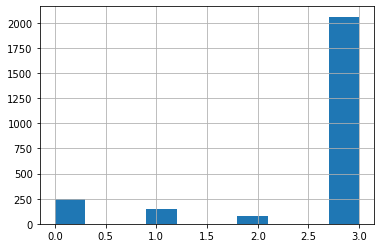

In [61]:
rslt_df['race'].hist()

In [62]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 shuffle=True):
        
        self.df = df.copy()
        self.n = len(df)
        self.X_col = X_col
        self.y_col = y_col
        self.n_race = df[y_col].nunique()
        print(self.n_race)
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        
    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0       
        return im
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def load_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col]
        race_batch = batches[self.y_col]

        X_batch = np.asarray([self.preprocess_image(x) for x in path_batch])
        y0_batch = np.asarray([self.__get_output(y, self.n_race) for y in race_batch])
        return X_batch, y0_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.load_data(batches)
        return X, y
    
    def __len__(self):
        return math.ceil(self.n/self.batch_size)

## Model Training and Accuracy Analysis

### Perform 5-fold cross validation

In [63]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [64]:
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
import math

save_dir = './checkpoint_dir/tensorflow_ckpt/'

# kfold parameters
kf = KFold(n_splits = 5, shuffle = True, random_state = 2)

# define variables
train_bsize = 32
test_bsize = 1
fold_var = 1
cm_holder = [] # confusion matrices holder
prf_holder = [] # precision_recall_f1 holder

result_holder = []
truth_holder = []


for train_index, test_index in kf.split(rslt_df):
    # generate splitted dataframe
    train_df = rslt_df.iloc[train_index]
    test_df = rslt_df.iloc[test_index]
    # create custom datasets for training/validation and class weights for balancing training dataset
    traingen = CustomDataGen(train_df,
                         X_col='img_filenames',
                         y_col='race',
                         batch_size=train_bsize)
    weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_df['race'])
                                               ,train_df['race'])
    weight = {i : weight[i] for i in range(4)}
    valgen = CustomDataGen(test_df,
                         X_col='img_filenames',
                         y_col='race',
                         batch_size=test_bsize, shuffle = False)
    
    IM_WIDTH = IM_HEIGHT = 198
    # create model
    model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=4)
    opt = Adam(lr=init_lr, decay=init_lr / epochs)
    model.compile(optimizer=opt, 
                  loss={

                      'race_output': 'categorical_crossentropy'
                      },
                  metrics={
                      'race_output': 'accuracy'
                      })
    # create CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(traingen, epochs=epochs, callbacks=callbacks_list,validation_data=valgen, class_weight = weight)
    
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("./checkpoint_dir/tensorflow_ckpt/model_"+str(fold_var)+".h5")
    
    results = model.predict(valgen)
    res = np.argmax(results, axis = 1)
    print(results.shape)
    print(res)
    print(res.shape)
    print(np.asarray(test_df['race'].to_list()))
    #results = dict(zip(model.metrics_names,results))
    #VALIDATION_ACCURACY.append(results['accuracy'])
    #VALIDATION_LOSS.append(results['loss'])
    cm_holder.append(confusion_matrix(np.asarray(test_df['race'].to_list()), res))
    report = classification_report(np.asarray(test_df['race'].to_list()), res, target_names=['Black', 'Hispanic/Latino','Asian','White'])
    print(report)
    result_holder.append(np.asarray(test_df['race'].to_list()))
    truth_holder.append(res)
    
    prf_holder.append(report)
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    


4
4


/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=0       3
1       2
2       3
3       3
5       2
       ..
2526    3
2527    3
2530    3
2531    3
2532    3
Name: race, Length: 2026, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 2.5039 - accuracy: 0.2567
Epoch 00001: val_accuracy improved from -inf to 0.02367, saving model to ./checkpoint_dir/tensorflow_ckpt/model_1.h5
64/64 [==============================] - 9s 142ms/step - loss: 2.5039 - accuracy: 0.2567 - val_loss: 3.4945 - val_accuracy: 0.0237
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 2.0660 - accuracy: 0.2685
Epoch 00002: val_accuracy did not improve from 0.02367
64/64 [==============================] - 7s 115ms/step - loss: 2.0660 - accuracy: 0.2685 - val_loss: 5.4393 - val_accuracy: 0.0237
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.8503 - accuracy: 0.2902 E
Epoch 00003: val_accuracy did not improve from 0.02367
64/64 [==============================] - 8s 123ms/step - loss: 1.8503 - accuracy: 0.2902 - val_loss: 7.1572 - val_accuracy: 0.0237
Epoch 4/200
64/64 [==============================] - ETA: 0s - loss: 1.7885 - accuracy: 0.287

/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=0       3
1       2
4       3
5       2
9       3
       ..
2528    3
2529    3
2530    3
2531    3
2532    3
Name: race, Length: 2026, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 2.3019 - accuracy: 0.2517
Epoch 00001: val_accuracy improved from -inf to 0.02959, saving model to ./checkpoint_dir/tensorflow_ckpt/model_2.h5
64/64 [==============================] - 8s 127ms/step - loss: 2.3019 - accuracy: 0.2517 - val_loss: 2.2483 - val_accuracy: 0.0296
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 2.1619 - accuracy: 0.2591
Epoch 00002: val_accuracy did not improve from 0.02959
64/64 [==============================] - 8s 123ms/step - loss: 2.1619 - accuracy: 0.2591 - val_loss: 2.7007 - val_accuracy: 0.0296
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.8717 - accuracy: 0.2878
Epoch 00003: val_accuracy improved from 0.02959 to 0.07101, saving model to ./checkpoint_dir/tensorflow_ckpt/model_2.h5
64/64 [==============================] - 8s 123ms/step - loss: 1.8717 - accuracy: 0.2878 - val_loss: 3.4569 - val_accuracy: 0.0710
Epoch 4/200
64/64 [===========

/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=0       3
1       2
2       3
3       3
4       3
       ..
2527    3
2528    3
2529    3
2530    3
2531    3
Name: race, Length: 2026, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 2.3550 - accuracy: 0.2611
Epoch 00001: val_accuracy improved from -inf to 0.03748, saving model to ./checkpoint_dir/tensorflow_ckpt/model_3.h5
64/64 [==============================] - 8s 128ms/step - loss: 2.3550 - accuracy: 0.2611 - val_loss: 3.1316 - val_accuracy: 0.0375
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.9796 - accuracy: 0.2868
Epoch 00002: val_accuracy did not improve from 0.03748
64/64 [==============================] - 8s 120ms/step - loss: 1.9796 - accuracy: 0.2868 - val_loss: 5.2485 - val_accuracy: 0.0375
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.9423 - accuracy: 0.2720
Epoch 00003: val_accuracy did not improve from 0.03748
64/64 [==============================] - 8s 118ms/step - loss: 1.9423 - accuracy: 0.2720 - val_loss: 7.0057 - val_accuracy: 0.0355
Epoch 4/200
64/64 [==============================] - ETA: 0s - loss: 1.8506 - accuracy: 0.2641


/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=2       3
3       3
4       3
5       2
6       3
       ..
2528    3
2529    3
2530    3
2531    3
2532    3
Name: race, Length: 2027, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 2.4424 - accuracy: 0.2329
Epoch 00001: val_accuracy improved from -inf to 0.06917, saving model to ./checkpoint_dir/tensorflow_ckpt/model_4.h5
64/64 [==============================] - 8s 120ms/step - loss: 2.4424 - accuracy: 0.2329 - val_loss: 2.7390 - val_accuracy: 0.0692
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.9693 - accuracy: 0.2728
Epoch 00002: val_accuracy did not improve from 0.06917
64/64 [==============================] - 7s 116ms/step - loss: 1.9693 - accuracy: 0.2728 - val_loss: 4.8414 - val_accuracy: 0.0356
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.7554 - accuracy: 0.2694
Epoch 00003: val_accuracy did not improve from 0.06917
64/64 [==============================] - 8s 118ms/step - loss: 1.7554 - accuracy: 0.2694 - val_loss: 6.7784 - val_accuracy: 0.0375
Epoch 4/200
64/64 [==============================] - ETA: 0s - loss: 1.8041 - accuracy: 0.2699


/share/pkg.7/python3/3.8.6/install/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=0       3
1       2
2       3
3       3
4       3
       ..
2526    3
2527    3
2528    3
2529    3
2532    3
Name: race, Length: 2027, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 2.3010 - accuracy: 0.2501
Epoch 00001: val_accuracy improved from -inf to 0.08893, saving model to ./checkpoint_dir/tensorflow_ckpt/model_5.h5
64/64 [==============================] - 8s 120ms/step - loss: 2.3010 - accuracy: 0.2501 - val_loss: 3.2776 - val_accuracy: 0.0889
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.9125 - accuracy: 0.2733
Epoch 00002: val_accuracy did not improve from 0.08893
64/64 [==============================] - 7s 114ms/step - loss: 1.9125 - accuracy: 0.2733 - val_loss: 4.1850 - val_accuracy: 0.0316
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.8200 - accuracy: 0.2733
Epoch 00003: val_accuracy improved from 0.08893 to 0.09091, saving model to ./checkpoint_dir/tensorflow_ckpt/model_5.h5
64/64 [==============================] - 7s 115ms/step - loss: 1.8200 - accuracy: 0.2733 - val_loss: 6.1173 - val_accuracy: 0.0909
Epoch 4/200
64/64 [===========

In [65]:
len(cm_holder)

5

In [68]:
cm_sum = np.zeros((4,4))

In [69]:
for each in cm_holder:
    cm_sum += each

In [70]:
cm_sum.astype(int)

array([[  58,   16,   17,  154],
       [  18,   12,    8,  108],
       [  11,    6,    7,   57],
       [ 273,   95,  107, 1586]])